In [1]:
import requests
import re
import sqlite3
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

In [2]:
def clean_text(text):
    # Remove any newlines and extra spaces from left and right
    text = (text.replace('\n', ' ')).strip()
    # Remove special character found on Candidate field
    text = text.replace('∇', '')
    # Remove unicode escape characters (found in Assets and Liabilities columns)
    if ("\xa0" in text and (text != "Nil" or text != "NIL")):
        text = (text.encode("ascii", "ignore")).decode()
        # Remove commas from amounts
        text = text.replace(",","")
        # Remove the currency denominator
        match = re.search(r"^Rs(\d+)~*",text)
        text = match.group(1)
    # Remove Nil(text) for the entire column to be integers
    if text == "Nil":
        text = ""
    # Convert strings which are only numbers to integers. Helpful when inserting into database
    if text.isdigit():
        text = int(text)
    return text

# Election candidate url
url = 'https://myneta.info/LokSabha2019/index.php?action=summary&subAction=candidates_analyzed&sort=candidate#summary'
# Fetch data from the site
print("Fetching data from the site")
page = requests.get(url)
# Parse the data as html
print("Parsing the data using BeautifulSoup")
soup = BeautifulSoup(page.content, 'html.parser')
# Find the required table 
#table = soup.find(text="CPI(M)").find_parent("table")
table = soup.find_all('table')[2]
# Find and Save the headings
print("Working on Headers")
headings = []
for th in table.find_all("th"):
    text = th.text.replace(" ", "")
    headings.append(clean_text(text))
print("Extracting data from the table")
table_data = []
#table_data.append(headings)
for row in table.find_all("tr")[2:]:
    table_data.append([clean_text(cell.get_text()) for cell in row.find_all("td")]) # list comprehension - new learning
print("Table data extracted")

Fetching data from the site
Parsing the data using BeautifulSoup
Working on Headers
Extracting data from the table
Table data extracted


In [3]:
# Fetch data from the site
response = requests.get("https://myneta.info/LokSabha2019/index.php?action=summary&subAction=winner_analyzed&sort=candidate#summary")
# Store it as a string
html_source = str(response.content)
# Using regex to find table
regex = "<table style=.*?>(.*?)</table>"
# Taking table 2 from the site
table = re.compile(regex, re.I | re.S).findall(html_source)[2]
# Using regex to find all rows
row_regex = "<tr>(.*?)</tr>"
rows = re.compile(row_regex, re.I | re.S).findall(table)[2:]
# Using regex to find all columns
col_regex = "<td.*?>(.*?)</td.*?>"
# Creating a new list to store all cells values
table_data1 = []
for row in rows:
    cells = re.compile(col_regex, re.I | re.S).findall(row)
    SNo = cells[0]
    Candidate = re.compile("<a href=.*?>(.*?)</a><b>").findall(cells[1])[0]
    Constituency = cells[2]
    Party = cells[3]
    Education = cells[5]
    Total_Assets = re.compile("Rs&nbsp;(.*?)<br>").findall(cells[6].replace(",",""))[0]
    Liabilities = re.compile("Rs&nbsp;(.*?)<br>").findall(cells[7].replace(",",""))[0]
    table_data1.append([SNo, Candidate, Constituency, Party, Education, Total_Assets, Liabilities])
print("Table Data 1 Extracted")
print(table_data1[1:10])

Table Data 1 Extracted
[['2', 'A Narayanaswamy', 'CHITRADURGA', 'BJP', 'Graduate', '96197642', '0'], ['3', 'A. Raja', 'NILGIRIS', 'DMK', 'Graduate Professional', '49591024', '1424914'], ['4', 'Abdul Khaleque', 'BARPETA', 'INC', 'Post Graduate', '7398753', '2703693'], ['5', 'Abhishek Banerjee', 'DIAMOND HARBOUR', 'AITC', 'Graduate', '13794320', '0'], ['6', 'Abu Hasem Khan Chowdhury', 'MALDAHA DAKSHIN', 'INC', 'Doctorate', '270959520', '728107'], ['7', 'Abu Taher Khan', 'MURSHIDABAD', 'AITC', '8th Pass', '8926616', '1350000'], ['8', 'Achyutananda Samanta', 'KANDHAMAL', 'BJD', 'Doctorate', '1244722', '0'], ['9', 'Adala Prabhakara Reddy', 'NELLORE', 'YSRCP', '12th Pass', '2211663364', '152281255'], ['10', 'Adhir Ranjan Chowdhury', 'BAHARAMPUR', 'INC', '10th Pass', '101315437', '8506984']]


In [4]:
# Create a connection to the database
print("Creating database connection")
conn = sqlite3.connect('india_election.db')

# Create a cursor
cursor = conn.cursor()

sql_query = 'DROP TABLE IF EXISTS candidates'
cursor.execute(sql_query)

# Build the SQL statement to create the table
sql_query = ('''CREATE TABLE candidates (
                Sno INTEGER PRIMARY KEY,
                Candidate TEXT NOT NULL,
                Constituency TEXT,
                Party TEXT,
                CriminalCase INTEGER,
                Education TEXT,
                TotalAssets INTEGER,
                Liabilities INTEGER
                )
            ''')

# Execute the SQL statement to create the table
print("Creating candidates table in the database")
cursor.execute(sql_query)

# Insert the data into the table
print("Inserting rows into candidates table")
cursor.executemany('INSERT INTO candidates VALUES (?, ?, ?, ?, ?, ?, ?, ?)', table_data)

# Save the changes to database
conn.commit()
print("Table created and data inserted successfully!")

Creating database connection
Creating candidates table in the database
Inserting rows into candidates table
Table created and data inserted successfully!


In [5]:
sql_query1 = 'DROP TABLE IF EXISTS winners'
cursor.execute(sql_query1)

# Build the SQL statement to create the table
sql_query1 = ("""CREATE TABLE winners (
                Sno varchar(5),
                Candidate varchar(100),
                Constituency varchar(50),
                Party varchar(50),
                Education varchar(50),
                TotalAssets int(10),
                Liabilities int(10)
                )
            """)

# Execute the SQL statement to create the table
print("Creating winners table in the database")
cursor.execute(sql_query1)

# Insert the data into the table
print("Inserting rows into winners table")

cursor.executemany('INSERT INTO winners VALUES (?, ?, ?, ?, ?, ?, ?)', table_data1)

# Save the changes to database
conn.commit()
print("Winners table created and data inserted successfully!")

Creating winners table in the database
Inserting rows into winners table
Winners table created and data inserted successfully!


In [6]:
# Verify the tables
print("Verify: Candidates with Criminal cases more than 15\n")
cursor.execute('SELECT * FROM candidates WHERE CriminalCase>15')
for row in cursor:
    print(row)

print("Verify: Winners with Assets more than 1billion\n")
cursor.execute('SELECT * FROM winners WHERE TotalAssets>1000000000')
for row in cursor:
    print(row)
    

Verify: Candidates with Criminal cases more than 15

(173, 'Adv.Prakash Babu', 'KOZHIKODE', 'BJP', 22, 'Post Graduate', 3524377, 343064)
(484, 'Anil Kumar', 'BUXAR', 'Jantantrik Vikas Party', 22, 'Graduate', 162240912, 13103750)
(568, 'Anumula Revanth Reddy', 'MALKAJGIRI', 'INC', 42, 'Graduate', 245357182, 27807304)
(618, 'Arjun Singh', 'BARRACKPUR', 'BJP', 24, '10th Pass', 8055691, 1100000)
(796, 'Ateek Ahmad', 'VARANASI', 'IND', 59, '8th Pass', 255020529, 0)
(851, 'B.B.Patil', 'ZAHIRABAD', 'TRS', 18, 'Graduate', 1287851556, 11535000)
(1014, 'Bapu Rao Soyam', 'ADILABAD', 'BJP', 52, '12th Pass', 3099414, 231450)
(1608, 'Dean Kuriakose', 'IDUKKI', 'INC', 204, 'Post Graduate', 13395011, 10000000)
(2264, 'George Tirkey', 'SUNDARGARH', 'INC', 41, '12th Pass', 901058, 0)
(2904, 'K Surendran', 'PATHANAMTHITTA', 'BJP', 240, 'Graduate', 4044300, 1308799)
(3102, 'Karia Dhirenbhai Amrutlal', 'JUNAGADH', 'IND', 28, '10th Pass', 82928865, 5796716)
(4575, 'Oli Mahammad Mallick', 'BARASAT', 'CPI(ML)

In [7]:
sql_query2 = 'DROP TABLE IF EXISTS candidates2'
cursor.execute(sql_query2)
cursor.execute(""" CREATE TABLE candidates2 AS
                       SELECT a.Sno, a.Candidate, a.Constituency, a.Party, a.CriminalCase, a.Education,
                       a.TotalAssets, a.Liabilities, b.Candidate
                       FROM candidates as a
                       LEFT JOIN winners as b ON a.Candidate = b.Candidate;
                """)
print("Verify: Candidates2 with Criminal cases more than 15\n")
cursor.execute('SELECT * FROM candidates2 WHERE CriminalCase>15')
for row in cursor:
    print(row)

Verify: Candidates2 with Criminal cases more than 15

(173, 'Adv.Prakash Babu', 'KOZHIKODE', 'BJP', 22, 'Post Graduate', 3524377, 343064, None)
(484, 'Anil Kumar', 'BUXAR', 'Jantantrik Vikas Party', 22, 'Graduate', 162240912, 13103750, None)
(568, 'Anumula Revanth Reddy', 'MALKAJGIRI', 'INC', 42, 'Graduate', 245357182, 27807304, 'Anumula Revanth Reddy')
(618, 'Arjun Singh', 'BARRACKPUR', 'BJP', 24, '10th Pass', 8055691, 1100000, 'Arjun Singh')
(796, 'Ateek Ahmad', 'VARANASI', 'IND', 59, '8th Pass', 255020529, 0, None)
(851, 'B.B.Patil', 'ZAHIRABAD', 'TRS', 18, 'Graduate', 1287851556, 11535000, 'B.B.Patil')
(1014, 'Bapu Rao Soyam', 'ADILABAD', 'BJP', 52, '12th Pass', 3099414, 231450, 'Bapu Rao Soyam')
(1608, 'Dean Kuriakose', 'IDUKKI', 'INC', 204, 'Post Graduate', 13395011, 10000000, 'Dean Kuriakose')
(2264, 'George Tirkey', 'SUNDARGARH', 'INC', 41, '12th Pass', 901058, 0, None)
(2904, 'K Surendran', 'PATHANAMTHITTA', 'BJP', 240, 'Graduate', 4044300, 1308799, None)
(3102, 'Karia Dhirenb

In [8]:
# Converting database into dataframe
MPs = pd.read_sql_query("SELECT * FROM candidates2", conn)
print("Converted into a dataframe successfully!")

# Verify the dataframe
print("MPs dataframe count of each column  \n",MPs.count())    

# Close the connection
conn.close()

Converted into a dataframe successfully!
MPs dataframe count of each column  
 Sno             7957
Candidate       7957
Constituency    7957
Party           7957
CriminalCase    7957
Education       7957
TotalAssets     7957
Liabilities     7957
Candidate:1      590
dtype: int64


In [9]:
display(MPs.describe())

,Sno,CriminalCase,Liabilities
count,7957.000000,7957.000000,7.957000e+03
mean,3979.000000,0.572075,5.580510e+06
std,2297.132379,4.063101,4.618961e+07
min,1.000000,0.000000,0.000000e+00
25%,1990.000000,0.000000,0.000000e+00
50%,3979.000000,0.000000,0.000000e+00
75%,5968.000000,0.000000,6.197550e+05
max,7957.000000,240.000000,1.547511e+09


In [10]:
# Asset type is shown as object, converting it to integer
display(MPs.dtypes)
MPs["TotalAssets"] = pd.to_numeric(MPs["TotalAssets"])
#MPs["TotalAssets"] = MPs['TotalAssets'].astype(np.int64)
display(MPs.dtypes)

Sno              int64
Candidate       object
Constituency    object
Party           object
CriminalCase     int64
Education       object
TotalAssets     object
Liabilities      int64
Candidate:1     object
dtype: object

Sno               int64
Candidate        object
Constituency     object
Party            object
CriminalCase      int64
Education        object
TotalAssets     float64
Liabilities       int64
Candidate:1      object
dtype: object

In [11]:
display(MPs.describe().apply(lambda s: s.apply(lambda x: format(x, 'g'))))

,Sno,CriminalCase,TotalAssets,Liabilities
count,7957,7957,7897,7957
mean,3979,0.572075,4.18214e+07,5.58051e+06
std,2297.13,4.0631,2.51683e+08,4.61896e+07
min,1,0,9,0
25%,1990,0,504000,0
50%,3979,0,2.7525e+06,0
75%,5968,0,1.307e+07,619755
max,7957,240,1.10758e+10,1.54751e+09


#Data Cleaning

In [12]:
# Changing column name for Candidate:1
MPs.rename(columns = {'Candidate:1':'Winner'}, inplace = True)
display(MPs.dtypes)
MPs.count()

Sno               int64
Candidate        object
Constituency     object
Party            object
CriminalCase      int64
Education        object
TotalAssets     float64
Liabilities       int64
Winner           object
dtype: object

Sno             7957
Candidate       7957
Constituency    7957
Party           7957
CriminalCase    7957
Education       7957
TotalAssets     7897
Liabilities     7957
Winner           590
dtype: int64

In [13]:
MPs['Winner'] = np.where(MPs['Winner'].isnull(), 0, 1)
# Verify
display(MPs['Winner'].unique())

array([0, 1])

In [14]:
MPs.head()
MPs = MPs.dropna()
MPs.count()

Sno             7897
Candidate       7897
Constituency    7897
Party           7897
CriminalCase    7897
Education       7897
TotalAssets     7897
Liabilities     7897
Winner          7897
dtype: int64

#Data Analysis

In [15]:
party_list = MPs.Party.values.tolist()
cloud_dict = {}
for word in party_list:
        if word in cloud_dict.keys():
            cloud_dict[word]+=1
        else:
            cloud_dict[word]=1
cloud_list = []
for w in cloud_dict:
    cloud_list.append((cloud_dict[w], w))
cloud_list.sort(reverse=True)
cloud_list[0:30]

[(3344, 'IND'),
 (435, 'BJP'),
 (420, 'INC'),
 (379, 'BSP'),
 (118, 'Bahujan Mukti Party'),
 (112, 'SUCI(C)'),
 (96, 'SHS'),
 (81, 'Pragatishil Samajwadi Party (Lohia)'),
 (76, 'Ambedkarite Party of India'),
 (69, 'CPI(M)'),
 (62, 'AITC'),
 (56, 'Peoples Party of India (Democratic)'),
 (53, 'Bharat Prabhat Party'),
 (50, 'SP'),
 (49, 'CPI'),
 (46, 'Vanchit Bahujan Aaghadi'),
 (46, 'Pyramid Party of India'),
 (46, 'Hindusthan Nirman Dal'),
 (36, 'Makkal Needhi Maiam'),
 (35, 'Naam Tamilar Katchi'),
 (35, 'AAP'),
 (34, 'NCP'),
 (34, 'Bhartiya Shakti Chetna Party'),
 (34, 'AIFB'),
 (31, 'RPI(A)'),
 (29, 'CPI(ML) Red Star'),
 (27, 'Bahujan Republican Socialist Party'),
 (26, 'Uttama Prajaakeeya Party'),
 (25, 'YSRCP'),
 (25, 'TDP')]

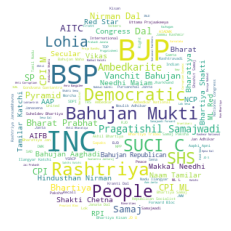

,Sno,Candidate,Constituency,Party,CriminalCase,Education,TotalAssets,Liabilities,Winner
0,1,Bajrang Vats,HISAR,IND,0,Graduate Professional,3189687.0,0,0
1,2,Bijender,HISAR,IND,0,5th Pass,3116503.0,630000,0
2,3,Mange Ram Verma,HISAR,IND,0,12th Pass,14704649.0,0,0
3,4,Pardeep Kumar,HISAR,IND,0,12th Pass,1073052.0,684517,0
4,5,Saleem Din,HISAR,IND,0,Others,112150.0,30100,0


In [16]:
#Create a word cloud with WordCloud
from os import path
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

#read the whole file into a text sring
for x in party_list:
    text += ' '+x

#update the STOPWORDS
stopwords = set(STOPWORDS)
stopwords.update(["INDIA","PARTY", "IND"])

#set a circle mask
import numpy as np
x, y = np.ogrid[:300, :300]

#Is point(x,y) more than 150 pixels away from the center?
mask = (x - 150) ** 2 + (y - 150) ** 2 > 150 ** 2
mask = 255 * mask.astype(int)
    
# Generate a word cloud image
wc = WordCloud(stopwords=stopwords, \
               background_color="white", \
               mask=mask, \
               max_font_size=40)
wc.generate(text)

# Display the generated image using matplotlib
plt.imshow(wc)
plt.axis("off")
plt.show()
MPs.head()

<AxesSubplot:title={'center':'Top 10 Political party with Highest Assets'}, xlabel='Party', ylabel='TotalAssets'>

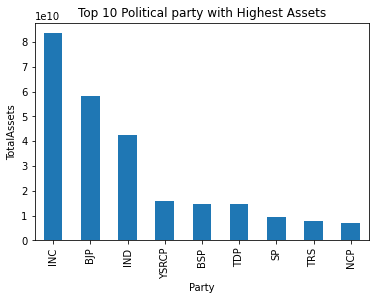

In [17]:
Assets_grouped = MPs.groupby(by="Party")["TotalAssets"].sum()
#print(Assets_grouped)
Assets_grouped = Assets_grouped.sort_values(ascending=False)
Assets_grouped[0:9].plot(kind='bar', title = "Top 10 Political party with Highest Assets", ylabel = "TotalAssets")

<AxesSubplot:title={'center':'Top 10 Political party with Highest Liabilities'}, xlabel='Party', ylabel='TotalLiabilities'>

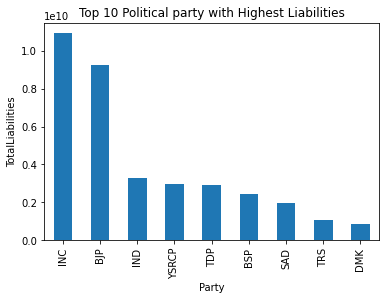

In [18]:
Liabilities_grouped = MPs.groupby(by="Party")["Liabilities"].sum()
#print(Liabilities_grouped)
Liabilities_grouped = Liabilities_grouped.sort_values(ascending=False)
Liabilities_grouped[0:9].plot(kind='bar', title = "Top 10 Political party with Highest Liabilities", ylabel = "TotalLiabilities" )

<AxesSubplot:title={'center':'% of Top 10 Political parties with Highest Criminal Cases'}, ylabel='CriminalCase'>

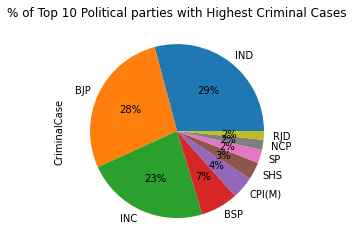

In [19]:
Cases_grouped = MPs.groupby(by="Party")["CriminalCase"].sum()
labels = ["INC", "BJP", "IND", "INC"]
Cases_grouped = Cases_grouped.sort_values(ascending=False)
Cases_grouped[0:9].plot(kind='pie', title = "% of Top 10 Political parties with Highest Criminal Cases", legend=False, autopct='%.0f%%')

In [20]:
National_Party = ["INC", "BJP", "AAP", "BSP", "CPI(M)", "CPI", "NCP", "NPP"]
MPs['Party_Type'] = np.where(MPs['Party'].isin(National_Party), "National", "Regional")
MPs['Party_Type'].unique()
MPs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7897 entries, 0 to 7956
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Sno           7897 non-null   int64  
 1   Candidate     7897 non-null   object 
 2   Constituency  7897 non-null   object 
 3   Party         7897 non-null   object 
 4   CriminalCase  7897 non-null   int64  
 5   Education     7897 non-null   object 
 6   TotalAssets   7897 non-null   float64
 7   Liabilities   7897 non-null   int64  
 8   Winner        7897 non-null   int32  
 9   Party_Type    7897 non-null   object 
dtypes: float64(1), int32(1), int64(3), object(5)
memory usage: 647.8+ KB


In [21]:
#Preprocessing: Dummy Coding categorical variables in training data
Party_dummies = pd.get_dummies(MPs['Party_Type'])
Education_dummies = pd.get_dummies(MPs['Education'])
extended_MPs = MPs.join([Party_dummies,Education_dummies])
display(extended_MPs.dtypes)

Sno                        int64
Candidate                 object
Constituency              object
Party                     object
CriminalCase               int64
Education                 object
TotalAssets              float64
Liabilities                int64
Winner                     int32
Party_Type                object
National                   uint8
Regional                   uint8
10th Pass                  uint8
12th Pass                  uint8
5th Pass                   uint8
8th Pass                   uint8
Doctorate                  uint8
Graduate                   uint8
Graduate Professional      uint8
Illiterate                 uint8
Literate                   uint8
Not Given                  uint8
Others                     uint8
Post Graduate              uint8
dtype: object

In [22]:
MPs.head()
extended_MPs.head()

,Sno,Candidate,Constituency,Party,CriminalCase,Education,TotalAssets,Liabilities,Winner,Party_Type,...,5th Pass,8th Pass,Doctorate,Graduate,Graduate Professional,Illiterate,Literate,Not Given,Others,Post Graduate
0,1,Bajrang Vats,HISAR,IND,0,Graduate Professional,3189687.0,0,0,Regional,...,0,0,0,0,1,0,0,0,0,0
1,2,Bijender,HISAR,IND,0,5th Pass,3116503.0,630000,0,Regional,...,1,0,0,0,0,0,0,0,0,0
2,3,Mange Ram Verma,HISAR,IND,0,12th Pass,14704649.0,0,0,Regional,...,0,0,0,0,0,0,0,0,0,0
3,4,Pardeep Kumar,HISAR,IND,0,12th Pass,1073052.0,684517,0,Regional,...,0,0,0,0,0,0,0,0,0,0
4,5,Saleem Din,HISAR,IND,0,Others,112150.0,30100,0,Regional,...,0,0,0,0,0,0,0,0,1,0


In [23]:
extended_MPs = extended_MPs[["Sno", "Candidate", "Constituency", "Party", "Party_Type", "Education", "TotalAssets", "Liabilities",
            "Winner", "National", "Regional", "10th Pass", "12th Pass", "5th Pass", "8th Pass", "Doctorate", "Graduate",
            "Graduate Professional", "Illiterate", "Literate", "Not Given", "Others", "Post Graduate", "CriminalCase"]]
extended_MPs.head()
extended_MPs["CriminalCase"].values

array([0, 0, 0, ..., 2, 0, 1], dtype=int64)

In [24]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
print("Creating training and testing data")
X = extended_MPs.iloc[:, 6:23].values
Y = extended_MPs["CriminalCase"].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)


Creating training and testing data


In [25]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)


In [26]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

In [32]:
print("Intercept: ",model.intercept_)
print("Coefficient: ",model.coef_)

Intercept:  0.6370170489558555
Coefficient:  [1.51313182e-02 1.38300000e-02 2.76086244e-01 1.18596271e+12
 1.18596271e+12 5.91272969e+13 5.82717709e+13 3.28691270e+13
 4.71495582e+13 2.27931451e+13 6.35775503e+13 5.23531635e+13
 2.23416450e+13 2.81663143e+13 7.41674852e+12 2.63324133e+13
 6.06468548e+13]


In [33]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
predictions = model.predict(X_test)
print(predictions)

[ 6.40377066e+12  6.40377066e+12 -5.70382356e+12 ...  6.40377066e+12
 -1.23888588e+13 -3.50278250e+12]


In [31]:
def models(X_train, Y_train):
    
    from sklearn.linear_model import LogisticRegression
    log = LogisticRegression(random_state = 0)
    log.fit(X_train, Y_train)
    
    from sklearn.neighbors import KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p=2)
    knn.fit(X_train, Y_train)
    
    from sklearn.svm import SVC
    svc_lin = SVC(kernel = 'linear', random_state=0)
    svc_lin.fit(X_train, Y_train)
    
    svc_rbf = SVC(kernel = 'rbf', random_state=0)
    svc_rbf.fit(X_train, Y_train)
    
    from sklearn.naive_bayes import GaussianNB
    gauss = GaussianNB()
    gauss.fit(X_train, Y_train)
    
    from sklearn.tree import DecisionTreeClassifier
    tree = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
    tree.fit(X_train, Y_train)
    
    from sklearn.ensemble import RandomForestClassifier
    forest = RandomForestClassifier(n_estimators=10, criterion = 'entropy', random_state = 0)
    forest.fit(X_train, Y_train)
    
    print('[0]Logistic Regression Training Accuracy: ', log.score(X_train, Y_train))
    print('[1]K Neighbors Training Accuracy: ', knn.score(X_train, Y_train))
    print('[2]SVC Linear Training Accuracy: ', svc_lin.score(X_train, Y_train))
    print('[3]SVC rbf Training Accuracy: ', svc_rbf.score(X_train, Y_train))
    print('[4]Gaussian NB Training Accuracy: ', gauss.score(X_train, Y_train))
    print('[5]Decision Tree Training Accuracy: ', tree.score(X_train, Y_train))
    print('[6]Random Forest Training Accuracy: ', forest.score(X_train, Y_train))
    
    return log, knn, svc_lin, svc_rbf, gauss, tree, forest

In [32]:
model = models(X_train, Y_train)

C:\Users\LabUser\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[0]Logistic Regression Training Accuracy:  0.8103530156719962
[1]K Neighbors Training Accuracy:  0.8171600443248377
[2]SVC Linear Training Accuracy:  0.8106696216558493
[3]SVC rbf Training Accuracy:  0.8120943485831882
[4]Gaussian NB Training Accuracy:  0.0074402406205477285
[5]Decision Tree Training Accuracy:  0.9957258192179832
[6]Random Forest Training Accuracy:  0.9642235238246003


In [33]:
from sklearn.metrics import *

for i in range(len(model)):
    predicted_y = model[i].predict(X_test)
    cm = confusion_matrix(Y_test, predicted_y)
    accuracy  = accuracy_score(Y_test, predicted_y)
    #print(cm)
    print('Model[{}] Testing Accuracy = "{}"'.format(i, accuracy))

Model[0] Testing Accuracy = "0.8082278481012658"
Model[1] Testing Accuracy = "0.8018987341772152"
Model[2] Testing Accuracy = "0.8088607594936709"
Model[3] Testing Accuracy = "0.8088607594936709"
Model[4] Testing Accuracy = "0.8088607594936709"
Model[5] Testing Accuracy = "0.6449367088607595"
Model[6] Testing Accuracy = "0.7341772151898734"
